In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
d = pd.read_csv('data/WaffleDivorce.csv', sep=';')

In [3]:
d.describe()

,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000
mean,6.119600,26.05400,20.114000,1.399400,9.688000,0.961800,32.340000,0.280000,79378.340000,6.287293e+05,0.094051
std,6.876156,1.24363,3.797905,0.796975,1.820814,0.525367,65.789587,0.453557,149730.921149,7.813127e+05,0.174449
min,0.560000,23.20000,13.500000,0.390000,6.100000,0.240000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.635000,25.32500,17.125000,0.810000,8.300000,0.572500,0.000000,0.000000,0.000000,4.332100e+04,0.000000
50%,4.435000,25.90000,19.700000,1.185000,9.750000,0.795000,1.000000,0.000000,0.000000,4.077220e+05,0.000000
75%,6.677500,26.75000,22.100000,1.767500,10.900000,1.257500,39.750000,1.000000,80828.000000,9.209770e+05,0.085000
max,37.250000,29.70000,30.700000,3.920000,13.500000,2.500000,381.000000,1.000000,490865.000000,3.880735e+06,0.570000


In [4]:
d.sample(5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
19,Maine,ME,1.33,26.4,13.5,1.40,13.0,1.48,0,0,0,628279,0.00
18,Louisiana,LA,4.53,25.9,20.6,1.19,11.0,0.89,66,1,331726,708002,0.47
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
13,Illinois,IL,12.83,27.0,17.9,0.58,8.0,0.45,2,0,0,1711951,0.00


In [5]:
scaler = StandardScaler()
d[['D', 'M', 'A']] = scaler.fit_transform(d[['Divorce', 'Marriage', 'MedianAgeMarriage']])

In [6]:
d[['D', 'M', 'A']].std()

D    1.010153
M    1.010153
A    1.010153
dtype: float64

In [7]:
def model(A, D=None):
    num_states = len(A)

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0.0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0.0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    mean_D = numpyro.deterministic('mean_D', alpha + beta*A)

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=D)

In [8]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, jnp.array(d['A']), jnp.array(d['D']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:02<00:00, 4511.27it/s, init loss: 2182.2070, avg. loss [9501-10000]: 61.2578]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.02      0.10      0.02     -0.14      0.17   9971.53      1.00
      beta     -0.52      0.11     -0.52     -0.69     -0.35  10073.15      1.00
 mean_D[0]      0.34      0.12      0.34      0.15      0.52  10060.49      1.00
 mean_D[1]      0.38      0.12      0.38      0.19      0.58  10068.59      1.00
 mean_D[2]      0.13      0.10      0.13     -0.03      0.29  10002.87      1.00
 mean_D[3]      0.76      0.18      0.76      0.46      1.04  10100.26      1.00
 mean_D[4]     -0.30      0.12     -0.29     -0.48     -0.10   9946.85      1.00
 mean_D[5]      0.17      0.10      0.17      0.00      0.33  10015.98      1.00
 mean_D[6]     -0.63      0.16     -0.63     -0.90     -0.36   9980.19      1.00
 mean_D[7]     -0.21      0.11     -0.21     -0.39     -0.04   9943.36      1.00
 mean_D[8]     -1.52      0.33     -1.53     -2.04     -0.96  10029.79      1.00
 mean_D[9]     -0.13      0

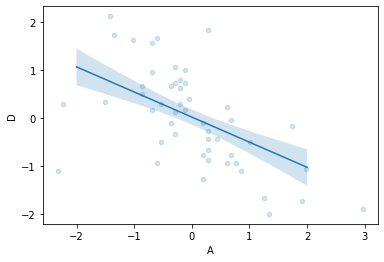

In [9]:
x = jnp.linspace(-2, 2)

_predictive = Predictive(model, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('A', 'D', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)

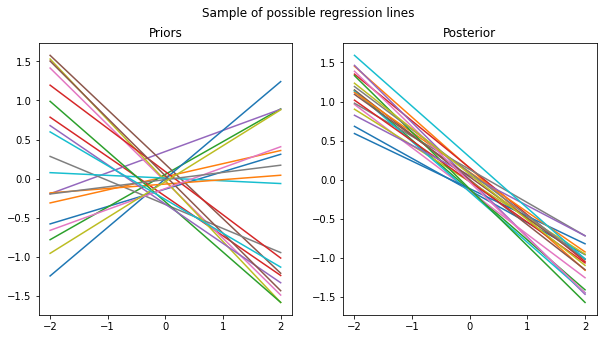

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Sample of possible regression lines')

prior_predictive = Predictive(model, num_samples=1000, return_sites=['mean_D'])
posterior_predictive = Predictive(model, samples, return_sites=['mean_D'])

prior_pred = prior_predictive(random.PRNGKey(2), jnp.array([-2,2]), None)
axes[0].set_title('Priors')
for i in range(20):
    axes[0].plot([-2,2], prior_pred['mean_D'][i])

posterior_pred = posterior_predictive(random.PRNGKey(2), jnp.array([-2,2]), None)
axes[1].set_title('Posterior')
for i in range(20):
    axes[1].plot([-2,2], posterior_pred['mean_D'][i])

In [11]:
def model(X, y=None):

    num_vars = X.shape[1]
    X = jnp.hstack([jnp.full((len(X),1), 1.0), X])

    # priors
    beta_list = []
    beta_list.append(numpyro.sample('alpha', dist.Normal(0.0,0.2)))
    for i in range(num_vars):
        beta_list.append(numpyro.sample('beta_' + str(i), dist.Normal(0.0,0.5)))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    beta = jnp.array(beta_list)
    mean_D = numpyro.deterministic('mean_D', jnp.matmul(X,beta))

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=y)

In [12]:
X = jnp.array(d[['A','M']])
y = jnp.array(d['D'])

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 8136.54it/s, init loss: 6360.3232, avg. loss [9501-10000]: 61.5911]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.08      0.10      0.08     -0.08      0.25   9990.20      1.00
    beta_0     -0.61      0.15     -0.61     -0.85     -0.35   9243.54      1.00
    beta_1     -0.05      0.15     -0.05     -0.30      0.19   9096.43      1.00
 mean_D[0]      0.45      0.13      0.45      0.23      0.67   9449.63      1.00
 mean_D[1]      0.42      0.20      0.42      0.08      0.76  10052.80      1.00
 mean_D[2]      0.20      0.10      0.20      0.04      0.37   9811.30      1.00
 mean_D[3]      0.85      0.21      0.85      0.52      1.22  10029.37      1.00
 mean_D[4]     -0.27      0.12     -0.27     -0.46     -0.07  10065.20      1.00
 mean_D[5]      0.21      0.15      0.21     -0.05      0.44  10057.12      1.00
 mean_D[6]     -0.64      0.17     -0.64     -0.91     -0.35  10038.86      1.00
 mean_D[7]     -0.23      0.20     -0.23     -0.54      0.11   9748.38      1.00
 mean_D[8]     -1.68      0

### Predictor residual plots

In [13]:
def model(A, M=None):
    num_states = len(A)

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0.0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0.0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    mean_M = numpyro.deterministic('mean_M', alpha + beta*A)

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_M, sigma), obs=M)

In [14]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, jnp.array(d['A']), jnp.array(d['M']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 7975.19it/s, init loss: 2335.2688, avg. loss [9501-10000]: 54.3143]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.09     -0.00     -0.16      0.14   9971.53      1.00
      beta     -0.74      0.10     -0.74     -0.91     -0.58  10073.67      1.00
 mean_M[0]      0.45      0.11      0.45      0.27      0.63  10059.24      1.00
 mean_M[1]      0.51      0.12      0.51      0.32      0.70  10067.36      1.00
 mean_M[2]      0.15      0.09      0.15     -0.00      0.31  10002.31      1.00
 mean_M[3]      1.05      0.17      1.05      0.77      1.32  10099.82      1.00
 mean_M[4]     -0.45      0.11     -0.45     -0.63     -0.27   9946.57      1.00
 mean_M[5]      0.21      0.10      0.21      0.05      0.37  10015.19      1.00
 mean_M[6]     -0.93      0.16     -0.93     -1.19     -0.68   9979.54      1.00
 mean_M[7]     -0.33      0.10     -0.33     -0.50     -0.16   9943.34      1.00
 mean_M[8]     -2.20      0.31     -2.20     -2.69     -1.67  10029.69      1.00
 mean_M[9]     -0.21      0

In [15]:
_predictive = Predictive(model, samples, return_sites=['mean_M'])
pred = _predictive(random.PRNGKey(2), jnp.array(d['A']), None)

mean_pred = pred['mean_M'].mean(axis=0)
resid = mean_pred - jnp.array(d['M'])

# fig, axes = plt.subplots(1,2)

# for i in range(len(mean_pred)):
#     x = d['A'].values[i]
#     axes[0].plot([x,x],[mean_pred[i], d['M'].iloc[i]], c="k", linewidth=0.5)
# axes[0].plot(d['A'].values, mean_pred,'o', label='Prediction')
# axes[0].plot(d['A'].values,d['M'].values, 'o', label='Actual')


In [16]:
def model(R, D=None):

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0.0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0.0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    mean_D = numpyro.deterministic('mean_D', alpha + beta*R)

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=D)

In [17]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, resid, jnp.array(d['D']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 6598.79it/s, init loss: 792.3110, avg. loss [9501-10000]: 71.3409]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.02      0.12     -0.02     -0.22      0.16   9971.53      1.00
      beta      0.12      0.19      0.12     -0.19      0.42  10073.24      1.00
 mean_D[0]      0.03      0.14      0.03     -0.20      0.26   9947.54      1.00
 mean_D[1]     -0.15      0.23     -0.15     -0.52      0.21  10101.40      1.00
 mean_D[2]     -0.01      0.12     -0.01     -0.20      0.18   9955.03      1.00
 mean_D[3]     -0.10      0.16     -0.10     -0.36      0.18  10083.79      1.00
 mean_D[4]     -0.05      0.12     -0.05     -0.25      0.15  10012.52      1.00
 mean_D[5]     -0.11      0.17     -0.11     -0.38      0.18  10089.19      1.00
 mean_D[6]     -0.04      0.12     -0.04     -0.23      0.16  10000.81      1.00
 mean_D[7]     -0.16      0.24     -0.16     -0.54      0.24  10102.13      1.00
 mean_D[8]     -0.21      0.31     -0.21     -0.70      0.31  10102.18      1.00
 mean_D[9]      0.05      0

Text(0, 0.5, 'Divorce rate (std)')

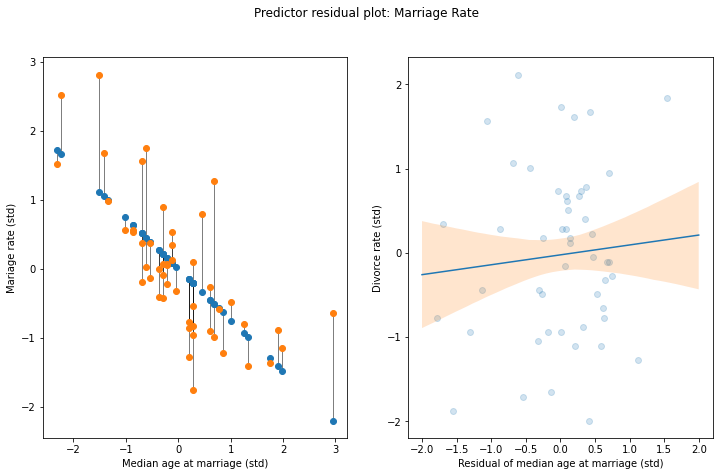

In [18]:
x = jnp.linspace(-2, 2)

_predictive = Predictive(model, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)

fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle("Predictor residual plot: Marriage Rate")

for i in range(len(mean_pred)):
    xi = d['A'].values[i]
    axes[0].plot([xi,xi],[mean_pred[i], d['M'].iloc[i]], c="k", linewidth=0.5)
axes[0].plot(d['A'].values, mean_pred,'o', label='Prediction')
axes[0].plot(d['A'].values,d['M'].values, 'o', label='Actual')
axes[0].set_xlabel('Median age at marriage (std)')
axes[0].set_ylabel('Mariage rate (std)')
axes[1].scatter(resid, d['D'].values, alpha=0.2)
axes[1].plot(x, loc)
axes[1].fill_between(x, low, high, alpha = 0.2)
axes[1].set_xlabel('Residual of median age at marriage (std)')
axes[1].set_ylabel('Divorce rate (std)')

### Posterior prediction plots

In [19]:
def model(X, y=None):

    num_vars = X.shape[1]
    X = jnp.hstack([jnp.full((len(X),1), 1.0), X])

    # priors
    beta_list = []
    beta_list.append(numpyro.sample('alpha', dist.Normal(0.0,0.2)))
    for i in range(num_vars):
        beta_list.append(numpyro.sample('beta_' + str(i), dist.Normal(0.0,0.5)))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    beta = jnp.array(beta_list)
    mean_D = numpyro.deterministic('mean_D', jnp.matmul(X,beta))

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=y)

In [20]:
X = jnp.array(d[['A','M']])
y = jnp.array(d['D'])

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:02<00:00, 3572.97it/s, init loss: 6360.3232, avg. loss [9501-10000]: 61.5911]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.08      0.10      0.08     -0.08      0.25   9990.20      1.00
    beta_0     -0.61      0.15     -0.61     -0.85     -0.35   9243.54      1.00
    beta_1     -0.05      0.15     -0.05     -0.30      0.19   9096.43      1.00
 mean_D[0]      0.45      0.13      0.45      0.23      0.67   9449.63      1.00
 mean_D[1]      0.42      0.20      0.42      0.08      0.76  10052.80      1.00
 mean_D[2]      0.20      0.10      0.20      0.04      0.37   9811.30      1.00
 mean_D[3]      0.85      0.21      0.85      0.52      1.22  10029.37      1.00
 mean_D[4]     -0.27      0.12     -0.27     -0.46     -0.07  10065.20      1.00
 mean_D[5]      0.21      0.15      0.21     -0.05      0.44  10057.12      1.00
 mean_D[6]     -0.64      0.17     -0.64     -0.91     -0.35  10038.86      1.00
 mean_D[7]     -0.23      0.20     -0.23     -0.54      0.11   9748.38      1.00
 mean_D[8]     -1.68      0

In [21]:
samples.keys()

dict_keys(['alpha', 'beta_0', 'beta_1', 'mean_D', 'sigma'])

In [22]:
_predictive = Predictive(model, samples, return_sites=['obs'])
pred = _predictive(random.PRNGKey(2), X, None)

loc = pred['obs'].mean(axis=0)
low, high = jnp.percentile(pred['obs'], jnp.array([5.0, 95.0]), axis=0)


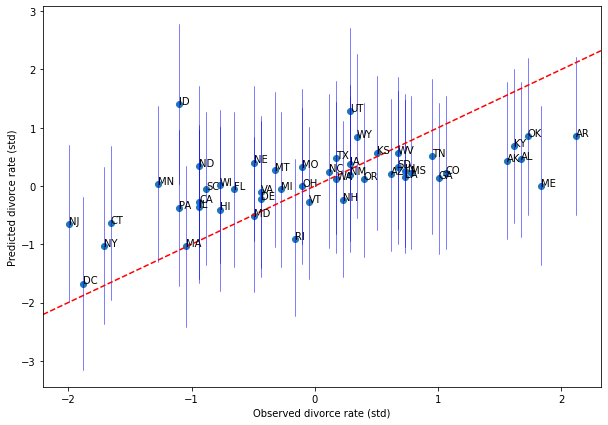

In [23]:
plt.figure(figsize=(10,7))
plt.scatter(d['D'], loc)
ax = plt.gca()
for i in range(len(loc)):
    xi = d['D'].values[i]
    ax.plot([xi,xi],[low[i], high[i]], color='b', linewidth=0.5)
    ax.annotate(d['Loc'].iloc[i], (xi, loc[i]))
ax.set_xlabel('Observed divorce rate (std)')
ax.set_ylabel('Predicted divorce rate (std)')
ax.axline([-2, -2], [2, 2], linestyle='--', color='r')

In [24]:
d = pd.read_csv('data/milk.csv', sep=';')
d.sample(10)
d.dropna(inplace=True)

In [25]:
d[['K', 'M', 'N']] = scaler.fit_transform(d[['kcal.per.g', 'mass', 'neocortex.perc']])

In [26]:
def MM1(X, y=None):
    if X.ndim == 1:
        num_vars = 1
        X = X.reshape(-1,1)
    else:
        num_vars = X.shape[1]
    X = jnp.hstack([jnp.full((len(X),1), 1.0), X])

    # priors
    beta_list = []
    beta_list.append(numpyro.sample('alpha', dist.Normal(0.0,0.2)))
    for i in range(num_vars):
        beta_list.append(numpyro.sample('beta_' + str(i), dist.Normal(0.0,0.5)))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    beta = jnp.array(beta_list)
    mean_D = numpyro.deterministic('mean_D', jnp.matmul(X,beta))

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=y)

In [27]:
# K <- N
X = jnp.array(d['N'])
y = jnp.array(d['K'])

GM1 = AutoLaplaceApproximation(MM1)
svi = SVI(MM1, GM1, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = GM1.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 9331.00it/s, init loss: 430.9325, avg. loss [9501-10000]: 24.5223]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.15      0.00     -0.26      0.24   9971.53      1.00
    beta_0      0.09      0.21      0.08     -0.26      0.43  10073.69      1.00
 mean_D[0]     -0.19      0.47     -0.18     -0.97      0.58  10100.82      1.00
 mean_D[1]     -0.05      0.19     -0.05     -0.36      0.25  10064.34      1.00
 mean_D[2]     -0.05      0.19     -0.05     -0.36      0.25  10064.34      1.00
 mean_D[3]      0.00      0.15      0.00     -0.26      0.24   9969.71      1.00
 mean_D[4]      0.02      0.16      0.02     -0.25      0.27   9946.56      1.00
 mean_D[5]     -0.13      0.35     -0.13     -0.68      0.46  10102.76      1.00
 mean_D[6]     -0.09      0.26     -0.09     -0.52      0.34  10097.35      1.00
 mean_D[7]     -0.11      0.30     -0.11     -0.61      0.37  10101.51      1.00
 mean_D[8]      0.04      0.18      0.04     -0.25      0.32   9944.28      1.00
 mean_D[9]      0.04      0

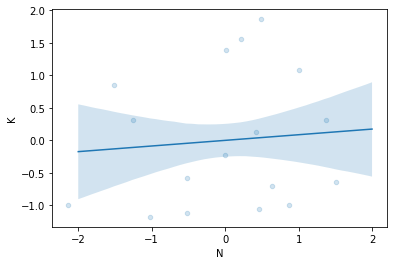

In [28]:
x = jnp.linspace(-2, 2)

_predictive = Predictive(MM1, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('N', 'K', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)

In [29]:
log_mass = np.log(d['mass'])
d['M'] = scaler.fit_transform(log_mass.values.reshape(-1,1))

100%|██████████| 10000/10000 [00:01<00:00, 8835.82it/s, init loss: 645.1022, avg. loss [9501-10000]: 23.7645]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.01      0.15     -0.01     -0.26      0.23   9971.53      1.00
    beta_0     -0.30      0.21     -0.30     -0.63      0.04  10073.76      1.00
 mean_D[0]      0.12      0.18      0.12     -0.17      0.40  10052.90      1.00
 mean_D[1]     -0.03      0.15     -0.03     -0.29      0.22   9959.08      1.00
 mean_D[2]     -0.04      0.15     -0.03     -0.29      0.21   9957.58      1.00
 mean_D[3]      0.08      0.16      0.08     -0.19      0.35  10030.42      1.00
 mean_D[4]      0.29      0.26      0.29     -0.15      0.69  10096.83      1.00
 mean_D[5]      0.57      0.43      0.57     -0.11      1.28  10101.89      1.00
 mean_D[6]      0.35      0.29      0.35     -0.13      0.82  10100.82      1.00
 mean_D[7]      0.41      0.33      0.41     -0.11      0.95  10102.49      1.00
 mean_D[8]      0.16      0.19      0.16     -0.15      0.48  10068.82      1.00
 mean_D[9]      0.04      0

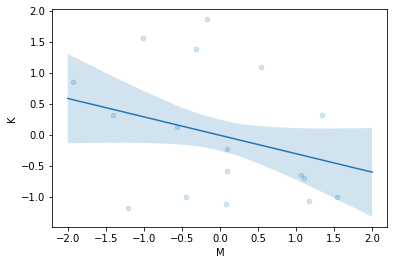

In [30]:
# K <- M
X = jnp.array(d['M'])
y = jnp.array(d['K'])

GM1 = AutoLaplaceApproximation(MM1)
svi = SVI(MM1, GM1, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = GM1.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

x = jnp.linspace(-2, 2)

_predictive = Predictive(MM1, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('M', 'K', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)


In [31]:
# K <- M + N
X = jnp.array(d[['M', 'N']])
y = jnp.array(d['K'])

GM1 = AutoLaplaceApproximation(MM1)
svi = SVI(MM1, GM1, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = GM1.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)


100%|██████████| 10000/10000 [00:01<00:00, 8294.92it/s, init loss: 715.6607, avg. loss [9501-10000]: 21.3533]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.13      0.00     -0.22      0.22   9990.20      1.00
    beta_0     -0.73      0.24     -0.74     -1.14     -0.35   9231.77      1.00
    beta_1      0.63      0.24      0.63      0.24      1.03   9964.34      1.00
 mean_D[0]     -1.03      0.47     -1.03     -1.77     -0.23  10026.27      1.00
 mean_D[1]     -0.39      0.19     -0.40     -0.70     -0.06  10054.67      1.00
 mean_D[2]     -0.40      0.20     -0.40     -0.71     -0.07  10053.01      1.00
 mean_D[3]      0.23      0.16      0.23     -0.04      0.47   9604.62      1.00
 mean_D[4]      0.88      0.31      0.88      0.33      1.36   9272.68      1.00
 mean_D[5]      0.47      0.36      0.47     -0.13      1.03   8938.83      1.00
 mean_D[6]      0.24      0.25      0.24     -0.17      0.64   9367.11      1.00
 mean_D[7]      0.24      0.28      0.24     -0.21      0.71   9407.66      1.00
 mean_D[8]      0.67      0

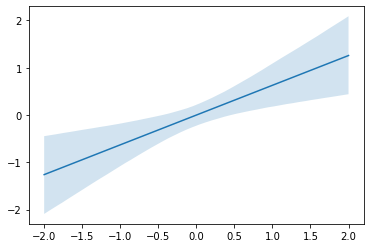

In [32]:
# Counterfactual to explore effect of varying N, holding M=0
n = jnp.linspace(-2, 2).reshape(-1,1)
m = jnp.zeros_like(n)
x = jnp.hstack([m,n])

_predictive = Predictive(MM1, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)
plt.plot(n, loc)
ax = plt.gca()
ax.fill_between(n.flatten(), low, high, alpha = 0.2)

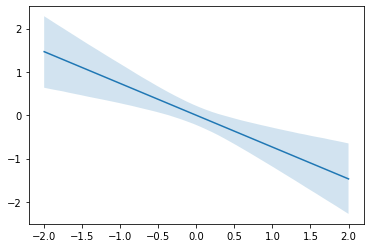

In [33]:
# Counterfactual to explore effect of varying M, holding N=0
m = jnp.linspace(-2, 2).reshape(-1,1)
n = jnp.zeros_like(m)
x = jnp.hstack([m,n])

_predictive = Predictive(MM1, samples, return_sites=['mean_D'])
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['mean_D'].mean(axis=0)
low, high = jnp.percentile(pred['mean_D'], jnp.array([5.0, 95.0]), axis=0)
plt.plot(m, loc)
ax = plt.gca()
ax.fill_between(m.flatten(), low, high, alpha = 0.2)

In [34]:
d = pd.read_csv('data/Howell1.csv', sep=';')
d2 = d[d['age'] >= 18]
sex_map = {1:'male', 0:'female'}
d2['sex_label'] = d2['male'].map(sex_map)



/tmp/ipykernel_295/3214960909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['sex_label'] = d2['male'].map(sex_map)


In [35]:
d2.sample(5)

,height,weight,age,male,sex_label
111,162.560,45.954540,35.0,1,male
318,164.465,52.163080,71.0,1,male
5,163.830,62.992589,35.0,1,male
446,158.115,46.521529,51.0,1,male
61,164.465,45.897841,50.0,1,male


### Page 175 examples

In [36]:
with handlers.seed(rng_seed=71):
    n = 1000
    h0 = numpyro.sample('h0', dist.Normal(10,2).expand([n,]))
    treatment = jnp.tile(jnp.array([0,1]),int(n/2))
    moist = numpyro.sample('moist', dist.BernoulliProbs(0.5).expand([n,]))
    fungus = numpyro.sample('fungus', dist.BernoulliProbs(0.5-treatment*0.4+moist*0.4).expand([n,]))
    h1 = h0 + numpyro.sample('h1', dist.Normal(5 + 3*moist, 1))

d = pd.DataFrame({'h0':h0, 'h1':h1, 'treatment':treatment, 'fungus':fungus, 'moist':moist})


In [37]:
# Predict h1 using treatment only...note treatment and fungus have no causal effect on h1 (it depends only on moist)
X = jnp.array(d[['h0','treatment', 'fungus']])
y = jnp.array(d['h1'])

G_T = AutoLaplaceApproximation(MM1)
svi = SVI(MM1, G_T, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = G_T.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:19<00:00, 519.79it/s, init loss: 2810.6685, avg. loss [9501-10000]: 2125.1382]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      1.61      0.18      1.61      1.31      1.89  10110.24      1.00
     beta_0      1.34      0.02      1.34      1.31      1.37  10070.65      1.00
     beta_1      1.05      0.12      1.05      0.87      1.25   9779.78      1.00
     beta_2      1.86      0.12      1.86      1.66      2.04  10127.54      1.00
  mean_D[0]     20.93      0.11     20.93     20.75     21.11  10146.62      1.00
  mean_D[1]     13.58      0.09     13.58     13.43     13.72   9637.87      1.00
  mean_D[2]     19.41      0.10     19.41     19.25     19.58  10222.60      1.00
  mean_D[3]     17.25      0.09     17.25     17.10     17.39   9325.94      1.00
  mean_D[4]     12.47      0.10     12.47     12.31     12.63  10395.89      1.00
  mean_D[5]     17.43      0.09     17.43     17.28     17.58   9323.54      1.00
  mean_D[6]     19.63      0.10     19.62     19.47     19.79  10210.10      1.00
  mean_D[7]    

In [38]:
class Person:

    # Attributes of Person class
    age_can_marry = 18
    retirement_age = 65
    coef_happiness = 0.1

    def __init__(self, rng_key, birth_year):
        # Instance attributes
        self.birth_year = birth_year
        self.rng_key = rng_key
        self.happiness = dist.Uniform().sample(rng_key)
        self.age = 0
        self.can_marry = False
        self.is_married = False
        self.is_retired = False
        self.marriage_age = jnp.nan
    
    # Age method
    def age_one_year(self):
        self.rng_key = random.split(self.rng_key,1)[0]

        # check for marriage
        if self.can_marry and not self.is_married and not self.is_retired:
            prob_marry = self.happiness * self.coef_happiness
            self.is_married = bool(dist.BernoulliProbs(prob_marry).sample(self.rng_key).item())
            self.marriage_age = self.age

        # increment year
        self.age += 1

        # check if eligible for marriage next iter
        if self.age >= self.age_can_marry:
            self.can_marry = True
        
        # check if retired
        if self.age >= self.retirement_age:
            self.is_retired = True

In [39]:

rng_key = random.PRNGKey(0)
num_years = 100
n_born_per_year = 20
person = {}
p = 0
results = {}
ridx = 0
for year in range(num_years):
    #print('year:', year)

    # add new births
    keys = random.split(rng_key,n_born_per_year + 1)
    rng_key = keys[-1]
    for np in range(n_born_per_year):
        person[p+np] = Person(keys[np], year)
    p += n_born_per_year
    #print('p:', year)

    for k, i in person.items():
        #print('person keys:', person.keys())
        # age all non-retired people by 1 year
        i.age_one_year()

        # gather attributes into array
        results[ridx] = {'person': k, 'year': year, 'age': i.age, 'happiness':i.happiness, 'is_married':i.is_married, 'is_retired':i.is_retired, 'can_marry':i.can_marry}
        ridx +=1

    # drop retred people person dict
    person = { k: v for k, v in person.items() if not v.is_retired }

print(len(results))


88400


In [40]:
results

{0: {'person': 0,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.30531085, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 1: {'person': 1,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.0904721, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 2: {'person': 2,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.67647827, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 3: {'person': 3,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.6412027, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 4: {'person': 4,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.15004945, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 5: {'person': 5,
  'year': 0,
  'age': 1,
  'happiness': DeviceArray(0.6977215, dtype=float32),
  'is_married': False,
  'is_retired': False,
  'can_marry': False},
 

In [41]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = jnp.repeat(jnp.arange(1, N_years + 1), N_births)

    # sim happiness trait - never changes
    H = jnp.repeat(jnp.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = jnp.zeros(N_years * N_births, dtype=jnp.int32)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = dist.Bernoulli(logits=(H - 4)).sample(random.PRNGKey(seed + i))
        return jnp.where((A >= i) & (M == 0), married, M)

    M = lax.fori_loop(aom, max_age + 1, update_M, M)
    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d


d = sim_happiness(seed=1977, N_years=100)
numpyro.diagnostics.print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)
print(len(d))


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     33.00     18.77     33.00      1.00     58.00      2.51      2.64
  happiness      0.00      1.21      0.00     -2.00      1.58    338.78      1.00
    married      0.29      0.45      0.00      0.00      1.00     95.64      1.23

1300


In [42]:
with handlers.seed(rng_seed=70):
    n = 200
    b_GP = 1
    b_PC = 1
    b_GC = 0
    b_U = 1 # same effect on P and C
    U = 2*numpyro.sample('U', dist.BernoulliProbs(0.5).expand([n,]))-1
    G = numpyro.sample('G', dist.Normal().expand([n,]))
    P = numpyro.sample('P', dist.Normal(b_GP*G + b_U*U))
    C = numpyro.sample('C', dist.Normal(b_GC*G + b_PC*P + b_U*U))

d = pd.DataFrame({'U':U, 'G':G, 'P':P, 'C':C})

In [43]:
d.describe()

,U,G,P,C
count,200.000000,200.000000,200.000000,200.000000
mean,-0.020000,0.176813,0.141998,0.113019
std,1.002309,1.041674,1.785794,2.689296
min,-1.000000,-2.957084,-5.546862,-5.014191
25%,-1.000000,-0.460344,-1.041075,-2.089395
50%,-1.000000,0.112103,0.144060,0.037038
75%,1.000000,0.882375,1.409487,2.272801
max,1.000000,2.468076,4.290937,7.318651


In [44]:
def MM2(X, y=None):
    if X.ndim == 1:
        num_vars = 1
        X = X.reshape(-1,1)
    else:
        num_vars = X.shape[1]
    X = jnp.hstack([jnp.full((len(X),1), 1.0), X])

    # priors
    beta_list = []
    beta_list.append(numpyro.sample('alpha', dist.Normal(0.0,1)))
    for i in range(num_vars):
        beta_list.append(numpyro.sample('beta_' + str(i), dist.Normal(0.0,1)))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))

    # regression
    beta = jnp.array(beta_list)
    mean_D = numpyro.deterministic('mean_D', jnp.matmul(X,beta))

    # sample obs
    numpyro.sample('obs', dist.Normal(mean_D, sigma), obs=y)

In [266]:
X = jnp.array(d[['P','G', 'U']])
y = jnp.array(d['C'])

G_1 = AutoLaplaceApproximation(MM2)
svi = SVI(MM2, G_1, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = G_1.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 5530.71it/s, init loss: 562.5113, avg. loss [9501-10000]: 266.3697]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.01      0.07      0.01     -0.10      0.12  10110.24      1.00
     beta_0      1.02      0.07      1.02      0.91      1.14   9597.15      1.00
     beta_1      0.06      0.09      0.06     -0.09      0.21   9780.60      1.00
     beta_2      1.01      0.10      1.01      0.85      1.17  10135.19      1.00
  mean_D[0]     -0.95      0.13     -0.95     -1.15     -0.74  10123.55      1.00
  mean_D[1]      1.74      0.11      1.74      1.56      1.92  10179.58      1.00
  mean_D[2]     -1.01      0.14     -1.01     -1.23     -0.79  10110.01      1.00
  mean_D[3]      2.85      0.10      2.85      2.69      3.02  10074.59      1.00
  mean_D[4]      3.94      0.13      3.94      3.74      4.16   9717.12      1.00
  mean_D[5]     -1.36      0.12     -1.36     -1.57     -1.17  10181.19      1.00
  mean_D[6]     -1.86      0.09     -1.86     -2.01     -1.70  10371.28      1.00
  mean_D[7]    

In [45]:
with handlers.seed(rng_seed=70):
    n = 1000
    b_XZ = 1
    b_ZY = 0.5
    X = numpyro.sample('X', dist.Normal().expand([n,]))
    Z = numpyro.sample('Z', dist.Normal(b_XZ*X))
    Y = numpyro.sample('Y', dist.Normal(b_ZY*Z))

d = pd.DataFrame({'X':X, 'Z':Z, 'Y':Y})

In [46]:
d.describe()

,X,Z,Y
count,1000.000000,1000.000000,1000.000000
mean,-0.017893,-0.051978,-0.024298
std,0.986098,1.413630,1.190398
min,-3.228360,-4.114484,-4.103837
25%,-0.723906,-0.987649,-0.848645
50%,-0.027532,-0.024023,0.028541
75%,0.677769,0.876114,0.748952
max,3.414514,4.982454,4.362553


In [49]:
X = jnp.array(d[['X','Z']])
y = jnp.array(d['Y'])

G_1 = AutoLaplaceApproximation(MM2)
svi = SVI(MM2, G_1, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, X, y)
params = svi_result.params

# display summary of quadratic approximation
samples = G_1.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:01<00:00, 6291.77it/s, init loss: 46207.0430, avg. loss [9501-10000]: 1393.8765]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.03      0.03      0.03     -0.02      0.08   9990.20      1.00
     beta_0     -0.02      0.04     -0.02     -0.09      0.05   9221.01      1.00
     beta_1      0.46      0.03      0.46      0.41      0.51   9968.91      1.00
  mean_D[0]      0.19      0.06      0.19      0.09      0.29   9314.44      1.00
  mean_D[1]      0.29      0.04      0.29      0.22      0.34   9865.50      1.00
  mean_D[2]     -1.47      0.09     -1.47     -1.62     -1.32   9136.22      1.00
  mean_D[3]      0.30      0.03      0.30      0.25      0.36  10034.16      1.00
  mean_D[4]     -0.08      0.03     -0.08     -0.14     -0.03  10073.63      1.00
  mean_D[5]     -0.31      0.06     -0.31     -0.41     -0.21   9102.68      1.00
  mean_D[6]     -0.68      0.06     -0.68     -0.77     -0.59  10037.42      1.00
  mean_D[7]     -0.38      0.04     -0.38     -0.44     -0.32   9992.06      1.00
  mean_D[8]    